In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("Layer11/train.csv")
df_valid = pd.read_csv("Layer11/valid.csv")
df_test = pd.read_csv("Layer11/test.csv")

In [3]:
df_train_X = df_train.copy()
df_train_X.drop(['label_2', 'label_3', 'label_4'], axis=1, inplace=True)
df_train_y = df_train_X.pop('label_1')

df_valid_X = df_valid.copy()
df_valid_X.drop(['label_2', 'label_3', 'label_4'], axis=1, inplace=True)
df_valid_y = df_valid_X.pop('label_1')

df_test_X = df_test.copy()
df_test_X.drop(['ID'], axis=1, inplace=True)

<AxesSubplot:>

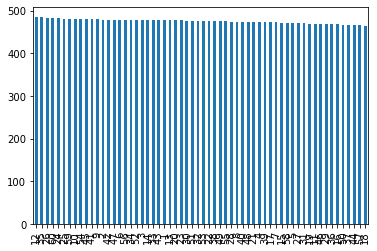

In [4]:
df_train['label_1'].value_counts().plot(kind='bar')

In [5]:
from scipy import stats

In [6]:
z_scores = abs(stats.zscore(df_train_y))
z_scores

0        0.836859
1        0.836859
2        0.836859
3        0.836859
4        0.836859
           ...   
28515    0.490600
28516    0.490600
28517    0.490600
28518    0.490600
28519    0.490600
Name: label_1, Length: 28520, dtype: float64

In [7]:
outliers = df_train_y[abs(z_scores) > 2]
outliers.count()

0

In [8]:
from sklearn.preprocessing import StandardScaler as ss

In [9]:
scaler = ss()
scaler.fit(df_train_X)
df_train_X_scaled = scaler.transform(df_train_X)
df_valid_X_scaled = scaler.transform(df_valid_X)
df_test_X_scaled = scaler.transform(df_test_X)

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [11]:
clf = SVC(kernel='linear')
scores = cross_val_score(clf, df_train_X_scaled, df_train_y, cv=5, scoring='accuracy')

In [12]:
scores

array([0.9200561 , 0.9154979 , 0.91304348, 0.91619916, 0.91374474])

In [13]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.92 accuracy with a standard deviation of 0.00


In [14]:
svc_initial = SVC(kernel="linear")
svc_initial.fit(df_train_X_scaled, df_train_y)

SVC(kernel='linear')

In [15]:
y_pred_initial = svc_initial.predict(df_valid_X_scaled)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [17]:
acs_initial = accuracy_score(df_valid_y, y_pred_initial)
pcs_initial = precision_score(df_valid_y, y_pred_initial, average='weighted')
rcs_initial = recall_score(df_valid_y, y_pred_initial, average='weighted')
print(f"Accuracy score before: {acs_initial:.4f}")
print(f"Precision score before: {pcs_initial:.4f}")
print(f"Recall score before: {rcs_initial:.4f}")

Accuracy score before: 0.9333
Precision score before: 0.9385
Recall score before: 0.9333


In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(0.995)
pca.fit(df_train_X_scaled)

pca_df_train_X = pca.transform(df_train_X_scaled)
pca_df_valid_X = pca.transform(df_valid_X_scaled)
pca_df_test_X = pca.transform(df_test_X_scaled)

In [20]:
pca_df_train_X.shape

(28520, 484)

In [21]:
from sklearn.model_selection import RandomizedSearchCV as rscv
from functools import partial
from scipy.stats import uniform, randint

In [22]:
param_dist = {
    'C':[0.1, 1, 10],
    'kernel': ['linear'],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.1, 1.0]
}

In [23]:
svc_tuning = SVC()
random_search = rscv(
    svc_tuning, 
    param_distributions=param_dist,
    n_iter=5, cv=5, n_jobs=-1, verbose=1)
random_search.fit(pca_df_train_X, df_train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                                        'gamma': [0.001, 0.1, 1.0],
                                        'kernel': ['linear']},
                   verbose=1)

In [24]:
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'kernel': 'linear', 'gamma': 1.0, 'degree': 2, 'C': 1}
Best Score: 0.9119915848527349


In [25]:
svc_after_tuning = SVC(**best_params)
svc_after_tuning.fit(pca_df_train_X, df_train_y)

SVC(C=1, degree=2, gamma=1.0, kernel='linear')

In [26]:
y_pred_after_tuning = svc_after_tuning.predict(pca_df_valid_X)

In [27]:
acs_after_tuning = accuracy_score(df_valid_y, y_pred_after_tuning)
pcs_after_tuning = precision_score(df_valid_y, y_pred_after_tuning, average='weighted')
rcs_after_tuning = recall_score(df_valid_y, y_pred_after_tuning, average='weighted')
print(f"Accuracy score after: {acs_after_tuning:.4f}")
print(f"Precision score after: {pcs_after_tuning:.4f}")
print(f"Recall score after: {rcs_after_tuning:.4f}")

Accuracy score after: 0.9267
Precision score after: 0.9339
Recall score after: 0.9267


In [70]:
import csv

In [71]:
IDs = [i+1 for i in range(len(y_pred_after_tuning))]

In [72]:
Data = {
    'ID': IDs,
    'label_1': y_pred_after_tuning 
}

In [73]:
data_frame = pd.DataFrame(Data)
data_frame.head

<bound method NDFrame.head of       ID  label_1
0      1       26
1      2       18
2      3       16
3      4        7
4      5       58
..   ...      ...
739  740       56
740  741       35
741  742       54
742  743       38
743  744       21

[744 rows x 2 columns]>

In [75]:
csv_file = 'Layer11_Label01.csv'
data_frame.to_csv(csv_file, index=False)